In [36]:
import medleydb as mdb
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import random
from os import path
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer

%load_ext line_profiler

HOME_PATH = path.expanduser("~")
UNSEEN_PATH = os.path.join(HOME_PATH, "data", "es_data",)
DATA_PATH = path.join(HOME_PATH, "data", "preprocessed")
MIX_PATH = path.join(HOME_PATH, "data", "medleydb", "medleydb", "Audio")
CACHE_PATH = path.join(HOME_PATH, "data", "cache")
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Ändra till detta i en paketstruktur
# DATA_PATH = path.join(path.dirname(__file__), 'data', 'preprocessed')

# Based off of OpenMICs taxonomy discussions and the MedleyDB taxonomy yaml
OPENMIC_TO_MEDLEY = {
    "drums": ["drum set"],
    "bass": ["electric bass", "double bass"],
    "guitar": ["distorted electric guitar", "clean electric guitar", "acoustic guitar"],
    "voice": [
        "male singer",
        "female singer",
        "male speaker",
        "female speaker",
        "male rapper",
        "female rapper",
        "beatboxing",
        "vocalists",
        "choir",
        "male screamer",
        "female screamer",
    ],
    "piano": ["piano", "tack piano", "electric piano"],
}

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key: i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}
MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}
NUM_LABELS = len(INSTRUMENTS)

def play_medley_audio(track):
    track_id = load_track(track).mix_path
    samples, sample_rate = librosa.load(track_id)
    ipd.display(ipd.Audio(samples, rate=sample_rate, autoplay=True))


def play_audio(track):
    homedir = os.path.expanduser("~")
    path = os.path.join(homedir, "data/es_data", track)
    samples, sample_rate = librosa.load(path)
    ipd.display(ipd.Audio(samples, rate=sample_rate, autoplay=True))


def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
def create_train_val_test_split(tracks, test_size=0.2, val_size=0.2):
    X = []
    Y = []

    for t in tracks:
        X.append(t)
        instruments = {
            MEDLEY_TO_OPENMIC[i]
            for i in t.stem_instruments
            if i in MEDLEY_TO_OPENMIC.keys()
        }
        Y.append(list(instruments))

    mlb = MultiLabelBinarizer(list(INSTRUMENTS))
    Y = mlb.fit_transform(Y)
    X = np.array(X)

    test_train = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=test_size, random_state=0
    )

    for train_index, test_index in test_train.split(X, Y):
        X_train, test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        break

    train_val = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=val_size, random_state=0
    )

    for train_index, test_index in train_val.split(X_train, Y_train):
        train, val = X_train[train_index], X_train[test_index]
        train_labels, val_labels = Y_train[train_index], Y_train[test_index]
        break

    print("Training sample length:", train.shape[0])
    print("Distribution:", np.sum(train_labels, axis=0))
    print("Validation sample length:", val.shape[0])
    print("Distribution:", np.sum(val_labels, axis=0))
    print("Test sample length", test.shape[0])
    print("Distribution:", np.sum(Y_test, axis=0))

    return train, val, test


tracks = mdb.load_all_multitracks(["V1", "V2"])
train, val, test = create_train_val_test_split(tracks, test_size=0.2, val_size=0.2)

# Example {"guitar": [stem_1.wav, ..., stem_n.wav], "bass": [stem_1.wav, ..., stem_n.wav]...}
def mdb_index(tracklist):
    files = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                files[instrument].append(v.audio_path)
    return files


# Example {"ArtistSong" : {"guitar" : [stem_1.wav, stem_2.wav]} }
def mdb_baseline_index(tracklist):
    files = {}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                if t.track_id not in files.keys():
                    files[t.track_id] = {k: [] for k, _ in OPENMIC_TO_MEDLEY.items()}
                files[t.track_id][instrument] = files[t.track_id].get(
                    instrument, []
                ) + [v.audio_path]
    return files


train_paths = mdb_baseline_index(train)
val_paths = mdb_baseline_index(val)
test_paths = mdb_baseline_index(test)

# samplerate = 16000
# window = 1024
# hop = 512
# duration = 8.191  # (8.192 - 0.001 because librosa round up)
# assert duration * samplerate / hop == 256
spectrogram_params = {
    "sample_rate": 16000,
    "spectrogram_len": 8.191,
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 128,
    "duration": 8.191,
    "num_windows": 256,
}

/home/carlnys/data/medleydb/medleydb/multitrack.py:368: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 124
Distribution: [67 78 59 56 54]
Validation sample length: 31
Distribution: [17 19 15 14 14]
Test sample length 41
Distribution: [22 25 19 18 18]


In [3]:
from joblib import Memory

# Creates a cache for function calls with certain parameters and their returns
memory = Memory(CACHE_PATH, verbose=0)
load = memory.cache(librosa.load)
get_duration = memory.cache(librosa.get_duration)


def x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    if offset is None:
        d = get_duration(filename=f)
        offset = random.randint(0, int(d - duration))

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = waveform[sr * offset : sr * offset + int(sr * duration)]

    y = librosa.feature.rms(waveform) > 0.01
    x = librosa.feature.melspectrogram(
        waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return x, y, offset


def mix(files, spectrogram_params, baseline=False):
    while True:
        xs = []
        ys = []
        paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}

        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if baseline:
            song_id, instrument_dict = random.choice(list(files.items()))
            d = None
            for instrument, stems in instrument_dict.items():
                for stem in stems:
                    paths[instrument].append(stem)
        else:
            for instrument, stems in files.items():
                paths[instrument].append(random.choice(stems))

        # invariant to input type
        for _, path_list in paths.items():
            y = np.zeros((1, spectrogram_params["num_windows"]))
            offset = None
            for path in path_list:
                x, _y, offset = x_y_from_stem(path, spectrogram_params, offset)
                y = np.logical_or(y, _y)
                xs.append(x)
            ys.append(y)

        x = np.sum(np.array(xs), axis=0)
        x = np.expand_dims(x, axis=0)
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)
        yield x, y


# files = index()
# train, test = split(files)
# train, validation = split(train)
## TODO batch, prefetch, cache(?), train, etc.
# for x, y in mix(train):
#    model.train(x, y)

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import medleydb as mdb
import librosa
import librosa.display
import IPython.display as ipd
import sklearn.metrics as metrics

%matplotlib notebook


class MedleyDB(Dataset):
    def __init__(self, files, spectrogram_params, baseline=False):
        self.files = files
        self.baseline = baseline
        self.spectrogram_params = spectrogram_params
        self.mixer = mix(self.files, self.spectrogram_params, self.baseline)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        length = 0
        if self.baseline:
            for k, v in self.files.items():
                for instrument, stems in v.items():
                    length += len(stems)
        else:
            for k, v in self.files.items():
                length += len(v)
        return length


batch_size = 16

train_data = MedleyDB(train_paths, spectrogram_params, True)
validation_data = MedleyDB(val_paths, spectrogram_params, True)
test_data = MedleyDB(test_paths, spectrogram_params, True)

train = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)
validation = DataLoader(
    validation_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)
test = DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)

In [54]:
def test_mix():
    gen = mix(val_paths, spectrogram_params, True)
    for i in range(10):
        x, y = next(gen)


%lprun -f x_y_from_stem test_mix()

In [55]:
def test_instrument_activations():
    y_tot = np.zeros((5, 256)).astype(float)
    gen = mix(train_paths, spectrogram_params, True)
    for i in range(1000):
        x, y = next(gen)
        y_tot += y

    y_tot = y_tot.sum(axis=1)
    return y_tot

In [168]:
y = test_instrument_activations()
print(y)

[102803. 148751. 118716.  80712.  89051.]


In [37]:
# def display_spectrogram(s, p):
#    librosa.display.specshow(
#        s, x_axis="time", y_axis="mel", sr=p["sample_rate"], hop_length=p["hop_length"]
#    )
#    plt.colorbar(format="%+2.0f dB")
#    plt.title("Mel-frequency spectrogram")
#    plt.tight_layout()
#    plt.show()
#
#
# x, y = next(iter(validation))
# s = x.numpy()[0]
# s1 = x.numpy()[1]
#
# comparison = s1 == s
# equal_arrays = comparison.all()
#
# print(equal_arrays)
#
#
# print(s.shape)
# l = y.numpy()[0]
# l2 = y.numpy()[1]
# print(l2)
# print(l.shape)
# np.set_printoptions(threshold=sys.maxsize)
# print(len(l[0]))
# display_spectrogram(s[0], spectrogram_params)

In [4]:
# Trying to mimic TUT-SED Synthetic 2016 in
# Convolutional Recurrent Neural Networks for
# Polyphonic Sound Event Detection
class CRNN(nn.Module):
    def __init__(self, gru_input, gru_hidden, gru_layers):
        super(CRNN, self).__init__()

        self.gru_input = gru_input
        self.gru_hidden = gru_hidden
        self.gru_layers = gru_layers

        # We only pool on the freq. axis
        self.pool_2x1 = nn.MaxPool2d([2, 1])
        self.pool_4x1 = nn.MaxPool2d([4, 1])

        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.conv4_bn = nn.BatchNorm2d(256)

        # now stack -> [batch_size, 256, 1, 256] -> [batch_size, 256*1, 256]

        # (input shape (w.o batch), hidden shape, n_layers, batch_first=True)
        self.gru = nn.GRU(gru_input, gru_hidden, gru_layers, batch_first=True)
        # torch.Size([batch_size, 256, 1, 256])
        self.fc = nn.Linear(256, 5)

    def forward(self, x, h):
        # print(x.shape)
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.pool_4x1(self.conv1_bn(self.conv1(x))))
        # print(x.shape)
        x = F.relu(self.pool_4x1(self.conv2_bn(self.conv2(x))))
        # print(x.shape)
        x = F.relu(self.pool_4x1(self.conv3_bn(self.conv3(x))))
        # print(x.shape)
        x = F.relu(self.pool_2x1(self.conv4_bn(self.conv4(x))))
        # print("After CNN", x.shape)
        # torch.Size([batch_size, 256, 1, 256])
        # (batch x classes x 1 x time) -> (batch x classes x time)
        x = x.view(x.shape[0], 256, 256)
        # Gru expects (batch, seq, feature)
        # The sequence in this case is our time axis
        x = x.permute(0, 2, 1)
        # print("After permute", x.shape)
        x, h = self.gru(x, h)
        # print("After gru", x.shape)
        x = self.fc(x)
        # print("After fc,", x.shape)
        # (batch_size, seq, num_classes)
        x = x.permute(0, 2, 1)
        # print("After permute back", x.shape)
        return x, h

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        # (n_layers, batch, n_hidden)
        h0 = Variable(torch.zeros(self.gru_layers, batch_size, self.gru_hidden)).cuda()
        return h0

In [5]:
gpu_available = torch.cuda.is_available()
lr = 0.001
batch_size = batch_size
model = CRNN(gru_input=256, gru_hidden=256, gru_layers=1)
params = model.parameters()
# Binary Cross-Entropy Loss
if gpu_available:
    model.cuda()
    criterion = nn.BCEWithLogitsLoss().cuda()
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 1
len_data = len(train.dataset)
print(len_data)
num_batches = len_data // batch_size

427


In [6]:
# Add best test acc, and classification report dict when running tests
def save_state(state, filename="state.pt"):
    torch.save(state, filename)

def train_model(model_name, crnn=False):
    validation_loss_min = sys.maxsize
    train_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs + 1):
        if crnn:
            h = model.init_hidden(batch_size)
            val_h = model.init_hidden(batch_size)
        print("Epoch: {}/{}".format(epoch, n_epochs))
        # keep track of training and validation loss
        train_loss = 0.0
        validation_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train):
            print("Batch: {}/{}".format(batch_idx, num_batches), end="\r")
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.float().cuda(), target.float().cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if crnn:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = model.init_hidden(data.shape[0])
                output, h = model(data, h)
            # forward pass: compute predicted outputs by passing inputs to the model
            # print(data.shape)
            else:
                output = model(data)
            # print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss, loss.item is the avarage loss of the batch.
            train_loss += loss.item() * data.size(0)

        ######################
        # validate the model #
        ######################
        model.eval()
        for data, target in validation:
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            if crnn:
                # Detatching hidden state from the computational graph
                # (see truncated back propagation through time) such that
                # the graph doesn't become super big, slowing down computations
                # and exploding the gradient.

                # Note however that the hidden state VALUE will still be inherited
                # We just say that it doesn't depend on previous hidden states
                val_h = model.init_hidden(data.shape[0])
                output, val_h = model(data, val_h)
            else:
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            validation_loss += loss.item() * data.size(0)

        # calculate average losses
        train_loss = train_loss / len(train.sampler)
        validation_loss = validation_loss / len(validation.sampler)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        # plot_loss(train_losses, validation_losses)
        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, validation_loss
            )
        )

        # save model if validation loss has decreased
        if validation_loss <= validation_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    validation_loss_min, validation_loss
                )
            )

            state = {
                "model_name": model_name,
                "epoch": epoch + 1,
                "lr": lr,
                "train_losses": train_losses,
                "validation_losses": validation_losses,
                "state_dict": model.state_dict(),
                "best_val_acc": validation_loss,
                "optimizer": optimizer.state_dict(),
            }

            if crnn:
                save_state(state, "%s.pt" % model_name)

            else:
                save_state(state, "%s.pt" % model_name)

            validation_loss_min = validation_loss

    state = {
        "model_name": model_name,
        "epoch": epoch + 1,
        "lr": lr,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
        "state_dict": model.state_dict(),
        "best_val_acc": validation_loss,
        "optimizer": optimizer.state_dict(),
    }

    if crnn:
        save_state(state, "overfit_%s.pt" % model_name)

    else:
        save_state(state, "overfit_%s.pt" % model_name)

In [ ]:
from sklearn.metrics import classification_report
def calculate_metrics(scores, predictions, targets):
    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=False
    )

    print(cr)

    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=True
    )
    # f1_macro = metrics.f1_score(targets, predictions, average='macro')
    # f1_micro = metrics.f1_score(targets, predictions, average='micro')
    lrap = metrics.label_ranking_average_precision_score(targets, scores)
    auc_roc_micro = metrics.roc_auc_score(targets, scores, average="micro")
    auc_roc_macro = metrics.roc_auc_score(targets, scores, average="macro")
    print("lrap:", lrap)
    print("AUC-ROC-Macro:", auc_roc_macro)
    print("AUC-ROC-Micro:", auc_roc_micro)
    cr["lrap"] = lrap
    cr["auc_roc_macro"] = auc_roc_macro
    cr["auc_roc_micro"] = auc_roc_micro
    return cr

# REMEMBER TO MANUALLY SIGMOID THE OUTPUTS SINCE THE LOSS DOES THAT FOR US
def test_model(model, crnn=True):
    model.eval()
    # track test loss
    test_loss = 0.0
    # iterate over test data

    labels_total = np.zeros(NUM_LABELS)
    correct_pred = np.zeros(NUM_LABELS)

    labels_total_test = torch.zeros(NUM_LABELS).cuda()
    correct_pred_test = torch.zeros(NUM_LABELS).cuda()

    scores = torch.zeros([0, NUM_LABELS]).cuda()
    predictions = torch.zeros([0, NUM_LABELS]).cuda()
    targets = torch.zeros([0, NUM_LABELS]).cuda()

    for idx, (data, target) in enumerate(test):
        if gpu_available:
            data, target = data.float().cuda(), target.float().cuda()

        # if idx == 0:
        #    # init here since we get data dims
        #    scores = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])
        #    predictions = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])
        #    targets = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])

        # forward pass: compute predicted outputs by passing inputs to the model
        if crnn:
            h = model.init_hidden(data.shape[0])
            output, h = model(data, h)
        else:
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class

        # Convert to score and use threshhold 0.5
        output = torch.sigmoid(output)

        pred = (output > 0.5).float()

        scores = torch.cat(
            [scores, output.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        predictions = torch.cat(
            [predictions, pred.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        targets = torch.cat(
            [targets, target.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )

        # compare predictions to true label
        correct = pred.eq(target.data.view_as(pred))
        # true_positives = np.logical_and(pred.cpu().numpy(), correct.cpu().numpy())
        true_positives = pred * correct

        labels_total_test = labels_total_test + torch.sum(
            target.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )
        correct_pred_test = correct_pred_test + torch.sum(
            true_positives.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )

        # Go through the batch, aggregate true positives
        # for i in range(target.shape[0]):
        # Elementwise addition

    # average test loss
    test_loss = test_loss / len(test)
    print("Ground truth true positives per class: ", labels_total_test.cpu().numpy())
    print("Predictied true positives per class: ", correct_pred_test.cpu().numpy())
    print("Test Loss: {:.6f}\n".format(test_loss))
    np.set_printoptions(suppress=True)
    return scores.cpu().numpy(), predictions.cpu().numpy(), targets.cpu().numpy()


# scores, predictions, targets = test_model(model, num_batches)
# scores, predictions, targets = test_model(model, num_batches, crnn=True)

def load_model_and_state(file, model, optimizer):
    state = torch.load(file)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state


def load_state(model_name):
    return torch.load("%s.pt" % model_name)


def run_tests(model_name, model, optimizer):
    print("=" * 80, "\n")
    state = load_model_and_state("%s.pt" % model_name, model, optimizer)
    print("Running Tests")
    scores, predictions, targets = test_model(model, crnn=True)
    print("=" * 80, "\n")
    print("Calculating Metrics")
    metrics = calculate_metrics(scores, predictions, targets)
    print("=" * 80, "\n")
    print("Saving")
    state["metrics"] = metrics
    save_state(state, "%s.pt" % model_name)
    return state

In [61]:
model_name = "test_model"
train_model(model_name=model_name, crnn=True)
#%lprun -f train_model train_model(model_name="mixing_model", crnn=True)
state = run_tests(model_name, model, optimizer)

Epoch: 1/1
Epoch: 1 	Training Loss: 0.509844 	Validation Loss: 0.546478
Validation loss decreased (9223372036854775808.000000 --> 0.546478).  Saving model ...

Running Tests
Ground truth true positives per class:  [14095. 15455. 14140. 10420.  7314.]
Predictied true positives per class:  [11057. 14111. 10141.  5562.  1194.]
Test Loss: 7.865033


Calculating Metrics
              precision    recall  f1-score   support

       drums       0.77      0.78      0.78     14095
        bass       0.75      0.91      0.82     15455
      guitar       0.91      0.72      0.80     14140
       voice       0.74      0.53      0.62     10420
       piano       0.19      0.16      0.17      7314

   micro avg       0.72      0.68      0.70     61424
   macro avg       0.67      0.62      0.64     61424
weighted avg       0.72      0.68      0.70     61424
 samples avg       0.42      0.45      0.42     61424



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


lrap: 0.811360847960413
AUC-ROC-Macro: 0.8121446434993148
AUC-ROC-Micro: 0.8282265168165028

Saving


In [7]:
# trial_data = DataLoader(
#    validation_data, batch_size=1, shuffle=True, num_workers=os.cpu_count()
# )
#
# data_gen = iter(trial_data)


def test_x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = waveform[int(sr * offset) : int(sr * offset) + int(sr * duration)]

    y = librosa.feature.rms(waveform) > 0.01
    x = librosa.feature.melspectrogram(
        waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return x, y


def test_mix(files, spectrogram_params, baseline=True):
    index = 0
    offset = 0
    next_song = True
    baseline_keys = []
    song_duration = 0

    song_name = ""
    full_mix_path = ""

    if baseline:
        baseline_keys = list(files.keys())

    while True:
        xs = []
        ys = []
        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if next_song:
            paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
            offset = 0
            if baseline:
                song_name = baseline_keys[index]
                instrument_dict = files[song_name]
                for instrument, stems in instrument_dict.items():
                    for stem in stems:
                        paths[instrument].append(stem)
                        song_duration = librosa.get_duration(filename=stem)
                        full_mix_path = (
                            "/".join(stem.split("/")[:-2])
                            + "/"
                            + song_name
                            + "_MIX.wav"
                        )
            next_song = False

        #print(song_name, offset)
        # invariant to input type
        for _, path_list in paths.items():
            y = np.zeros((1, spectrogram_params["num_windows"]))
            for path in path_list:
                x, _y = test_x_y_from_stem(path, spectrogram_params, offset)
                y = np.logical_or(y, _y)
                xs.append(x)
            ys.append(y)

        offset += spectrogram_params["duration"]

        x = np.sum(np.array(xs), axis=0)
        x = np.expand_dims(x, axis=0)
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)

        if offset + spectrogram_params["duration"] > song_duration:
            offset = 0
            index += 1
            next_song = True

        yield x, y, next_song, full_mix_path


class TestDB(Dataset):
    def __init__(self, files, spectrogram_params, baseline=True):
        self.files = files
        self.baseline = baseline
        self.spectrogram_params = spectrogram_params
        self.mixer = test_mix(self.files, self.spectrogram_params, self.baseline)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        return 10000000

whole_song_data = TestDB(val_paths, spectrogram_params, True)
whole_song = DataLoader(whole_song_data, batch_size=1, shuffle=False)
data_gen = iter(whole_song)

<IPython.core.display.Javascript object>


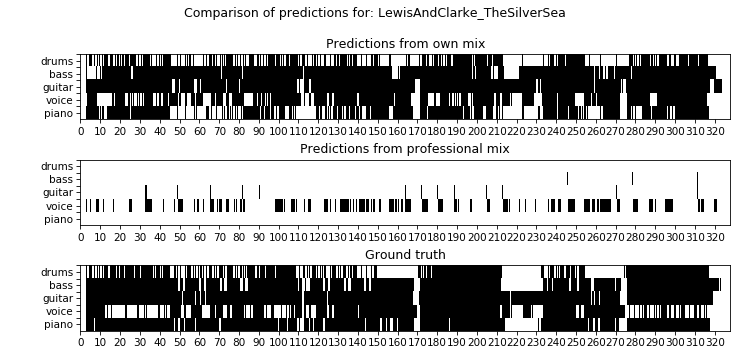

In [44]:
# https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
# https://stackoverflow.com/questions/36437584/how-to-set-xticks-and-yticks-with-my-imshow-plot
def compare_predictions_with_ground_truth(song_name, p, p_mix, g_t):
    duration = 0.032 * p.shape[1]
    cmap = mpl.colors.ListedColormap(["white", "black"])
    width = 100
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    #labels = [REV_INSTRUMENT_INDEX[x] + [""] for x in range(predictions.shape[0])]
    labels = []
    for i in range(NUM_LABELS):
        labels = labels + [""] + [REV_INSTRUMENT_INDEX[i]]
    fig.suptitle("Comparison of predictions for: %s" % song_name)
    ax1.set_title("Predictions from own mix")
    ax2.set_title("Predictions from professional mix")
    ax3.set_title("Ground truth")
    
    ax1.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax1.set_xticks(np.arange(0, duration, step=10))
    ax1.set_yticklabels(labels)
    im1 = ax1.imshow(p, interpolation="nearest", extent = [0, duration, 5, 0], cmap=cmap, aspect="auto")
    divider1 = make_axes_locatable(ax1)
    # ax3.set_yticks()
    # ax3.set_xticks()

    ax2.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax2.set_xticks(np.arange(0, duration, step=10))
    ax2.set_yticklabels(labels)
    im2 = ax2.imshow(p_mix, interpolation="nearest", extent = [0, duration, p.shape[0], 0], cmap=cmap, aspect="auto")
    divider2 = make_axes_locatable(ax2)

    ax3.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax3.set_xticks(np.arange(0, duration, step=10))
    ax3.set_yticklabels(labels)
    im3 = ax3.imshow(g_t, interpolation="nearest", extent = [0, duration, p.shape[0], 0], cmap=cmap, aspect="auto")
    divider3 = make_axes_locatable(ax3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def create_spectrograms(track, spectrogram_params):
    duration = spectrogram_params["spectrogram_len"]
    n_fft = spectrogram_params["n_fft"]
    hop_length = spectrogram_params["hop_length"]
    n_mels = spectrogram_params["n_mels"]
    sr = spectrogram_params["sample_rate"]

    y, sr = librosa.load(track, sr=sr)
    assert len(y) // sr > duration
    samples_per_spectrogram = int(sr * duration)
    num_spectrograms = len(y) // samples_per_spectrogram
    # Remove samples that doesn't divide equally with s_p_s
    y = y[: num_spectrograms * samples_per_spectrogram]
    spectrograms = []
    # could optimize by saving spectrograms directly here
    # however imo code is cleaner if saved in helper func
    for i in range(0, len(y), samples_per_spectrogram):
        waveform = y[i : i + samples_per_spectrogram]
        x = librosa.feature.melspectrogram(
            waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
        spectrograms.append(x)
    spectrograms = np.stack(spectrograms, axis=0)
    return spectrograms


model.load_state_dict(torch.load("500_epoch_crnn_mixing_model.pt"))

next_song = False
predictions = torch.zeros([len(INSTRUMENTS), 0]).cuda()
predictions_from_mix = torch.zeros([len(INSTRUMENTS), 0]).cuda()
ground_truth = torch.zeros([len(INSTRUMENTS), 0]).cuda()

idx = 0
spectrograms = None
while next_song == False:
    x, y, next_song, mix_path = next(data_gen)
    next_song = next_song.numpy()[0]
    mix_path = mix_path[0]
    if spectrograms is None:
        spectrograms = create_spectrograms(mix_path, spectrogram_params)
    s = spectrograms[idx]
    s = np.expand_dims(s, axis=0)
    s = np.expand_dims(s, axis=0)
    s = torch.from_numpy(s).cuda()
    h = model.init_hidden(1)
    output, h = model(s, h)
    predictions_from_mix = torch.cat(
        [predictions_from_mix, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
    )

    x = x.cuda()
    y = y.cuda()
    model.eval()
    h = model.init_hidden(1)
    output, h = model(x, h)
    predictions = torch.cat(
        [predictions, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
    )
    ground_truth = torch.cat([ground_truth, y[0].float()], axis=1)
    idx += 1

song_name = mix_path.split("/")[-2]
# visualize_song_predictions(predictions.cpu())
compare_predictions_with_ground_truth(song_name,
    predictions.cpu().numpy(),
    predictions_from_mix.cpu().numpy(),
    ground_truth.cpu().numpy(),
)

#play_medley_audio(song_name)

In [40]:
model.load_state_dict(torch.load("500_epoch_crnn_mixing_model.pt"))
scores, predictions, targets = test_model(model, crnn=True)
cr = calculate_metrics(scores, predictions, targets)

Ground truth true positives per class:  [12756. 15962. 12507.  8529.  9495.]
Predictied true positives per class:  [ 9688. 13270. 11578.  7696.  5989.]
Test Loss: 5.067631

              precision    recall  f1-score   support

       drums       0.87      0.76      0.81     12756
        bass       0.87      0.83      0.85     15962
      guitar       0.83      0.93      0.87     12507
       voice       0.70      0.90      0.79      8529
       piano       0.63      0.63      0.63      9495

   micro avg       0.79      0.81      0.80     59249
   macro avg       0.78      0.81      0.79     59249
weighted avg       0.80      0.81      0.80     59249
 samples avg       0.66      0.67      0.65     59249



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


lrap: 0.9265671136810848
AUC-ROC-Macro: 0.9328036781898911
AUC-ROC-Micro: 0.9358743067026286


In [42]:
model.load_state_dict(torch.load("500_epoch_overfit_crnn_mixing_model.pt"))
scores, predictions, targets = test_model(model, crnn=True)
cr = calculate_metrics(scores, predictions, targets)

Ground truth true positives per class:  [15350. 15614. 14996. 10482.  9245.]
Predictied true positives per class:  [13421. 15251. 10970. 10022.  5234.]
Test Loss: 5.918080

              precision    recall  f1-score   support

       drums       0.88      0.87      0.88     15350
        bass       0.79      0.98      0.87     15614
      guitar       0.85      0.73      0.79     14996
       voice       0.74      0.96      0.83     10482
       piano       0.67      0.57      0.61      9245

   micro avg       0.80      0.84      0.82     65687
   macro avg       0.79      0.82      0.80     65687
weighted avg       0.80      0.84      0.81     65687
 samples avg       0.67      0.70      0.67     65687



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


lrap: 0.8982519702126925
AUC-ROC-Macro: 0.9255104024900778
AUC-ROC-Micro: 0.9211876600095402


In [43]:
model.load_state_dict(torch.load("crnn_baseline_mixing_model.pt"))
scores, predictions, targets = test_model(model, crnn=True)
cr = calculate_metrics(scores, predictions, targets)

Ground truth true positives per class:  [10411. 15572. 13219.  9896.  8498.]
Predictied true positives per class:  [ 7962. 13549.  9569.  8450.  7084.]
Test Loss: 5.406033

              precision    recall  f1-score   support

       drums       0.77      0.76      0.77     10411
        bass       0.81      0.87      0.84     15572
      guitar       0.94      0.72      0.82     13219
       voice       0.82      0.85      0.84      9896
       piano       0.61      0.83      0.70      8498

   micro avg       0.79      0.81      0.80     57596
   macro avg       0.79      0.81      0.79     57596
weighted avg       0.80      0.81      0.80     57596
 samples avg       0.71      0.72      0.69     57596



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


lrap: 0.9173313784995459
AUC-ROC-Macro: 0.9292832434817109
AUC-ROC-Micro: 0.926319909794477
